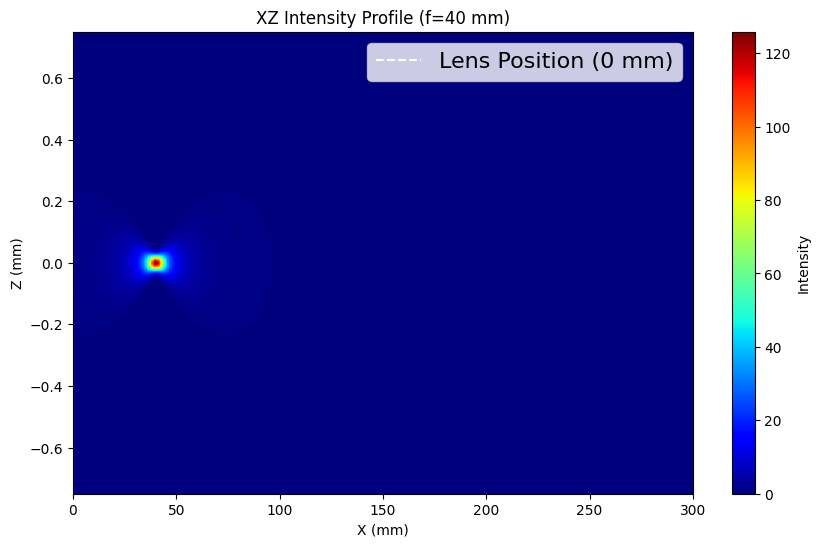

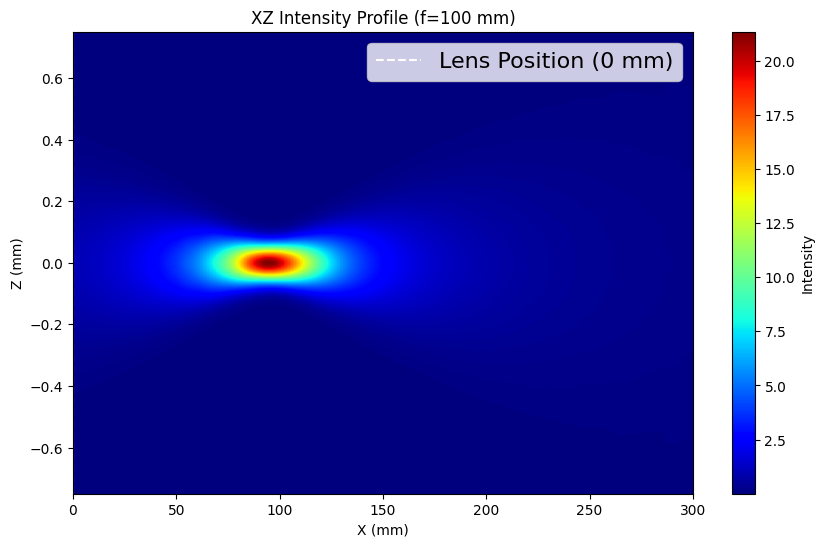

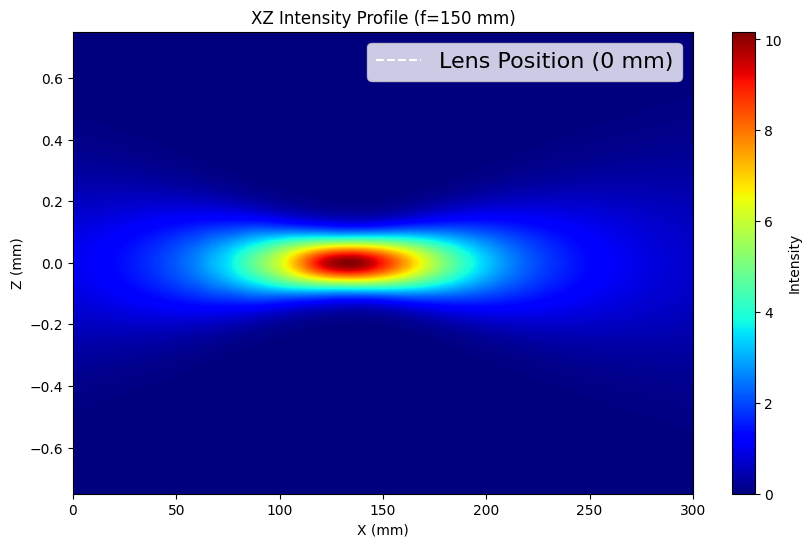

Focal Length: 40 mm
  New Waist Size (W0): 0.03 mm
  Waist Location (z0): 39.20 mm

Focal Length: 100 mm
  New Waist Size (W0): 0.08 mm
  Waist Location (z0): 94.97 mm

Focal Length: 150 mm
  New Waist Size (W0): 0.12 mm
  Waist Location (z0): 134.17 mm



In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Beam propagation using angular spectrum method
def angular_spectrum_method_with_padding(field, z_arr, wavelength, dx, dy, pad_width, alpha, bandwidth_limit=True):
    # Propagation constant
    k = 2 * np.pi / wavelength

    # Padding on input field to increase the array size
    padded_field = np.pad(field, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant')

    # Creating an absorption mask
    Nx, Ny = padded_field.shape
    x = np.linspace(-1, 1, Nx)
    y = np.linspace(-1, 1, Ny)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    absorption_mask = np.exp(-alpha * np.maximum(r - 1 + 2 * pad_width / max(Nx, Ny), np.zeros_like(r))**2)

    # Applying the absorption mask
    padded_field *= absorption_mask

    # Fourier Transform of the input field
    field_ft = np.fft.fft2(padded_field)

    # Spatial frequencies
    kx = np.fft.fftfreq(Nx, dx) * 2 * np.pi
    ky = np.fft.fftfreq(Ny, dy) * 2 * np.pi
    kx, ky = np.meshgrid(kx, ky, indexing="ij")

    # Bandwidth limiting
    if bandwidth_limit:
        k_max = k
        mask = (kx**2 + ky**2 <= k_max**2)
        field_ft *= mask

    # kz in the frequency domain
    kz = np.sqrt(np.clip(k**2 - kx**2 - ky**2, 0, None))

    # Creating an empty array "propagated_fields" with the same shape of "field" array
    propagated_fields = np.empty((len(z_arr), field.shape[0], field.shape[1]), dtype=np.complex128)

    # Loop to find propagating field at each point of z
    for count, z in enumerate(z_arr):  # Looping over z
        # Propagation phase factor
        phase_factor = np.exp(1j * kz * z)

        # Propagated field in the frequency domain
        propagated_field_ft = field_ft * phase_factor

        # Inverse Fourier Transform to get the field at distance z
        propagated_field = np.fft.ifft2(propagated_field_ft)

        # Removing padding
        propagated_field = propagated_field[pad_width:-pad_width, pad_width:-pad_width]
        propagated_fields[count, :, :] = propagated_field

    return propagated_fields

# Second moment calculation
def second_moment(x, y, I):
    numx = np.trapz(np.trapz(I * x**2, x, axis=0), y, axis=0)
    numy = np.trapz(np.trapz(I * y**2, y, axis=0), x, axis=0)
    den = np.trapz(np.trapz(I, y, axis=0), x, axis=0)
    return numx, numy, den

# Calculate the beam radius in x and y directions for all positions in z
def beam_width(Wx, Wy):
    W = np.sqrt(Wx**2 + Wy**2)
    return W

# Parameters
wavelength = 1e-3  # Wavelength in mm
Wo = 0.38  # Beam waist in mm
pad_width = 140  # Padding width
abs_coeff = 8  # Absorption coefficient

# Grid parameters
grid_size = 700
grid_extent = 1.5  # Reduced extent of the grid in mm for finer detail
dx = dy = grid_extent / grid_size



# Lens positions and focal lengths
lens_position = 0  # Position of lens in mm
focal_lengths = [40, 100, 150]  # Focal lengths in mm

# Coordinate grid
x = np.linspace(-grid_extent / 2, grid_extent / 2, grid_size)
y = np.linspace(-grid_extent / 2, grid_extent / 2, grid_size)
X, Y = np.meshgrid(x, y)

# Lists to hold results for each focal length
all_Wx = []
all_Wy = []
all_W_sim = []
all_W_th = []

# Initial Gaussian beam field
initial_field = np.exp(-(X**2 + Y**2) / Wo**2)

# Plotting for each focal length
for focal_length in focal_lengths:
    # Array for position in z axis from 0 to lens position
    z_pos = np.linspace(lens_position, 300, 200)
    # Lens phase
    lens_phase = np.exp(-1j * (np.pi / (wavelength * focal_length)) * (X**2 + Y**2))

    # Apply the lens phase transformation at the lens position
    field_at_lens = initial_field * lens_phase
    field_after_lens = angular_spectrum_method_with_padding(field_at_lens, z_pos, wavelength, dx, dy, pad_width, abs_coeff)
    intensity_after_lens = np.abs(field_after_lens)**2
    XZ_intensity_profile = intensity_after_lens[:, :, grid_size // 2]
    # Plot the XZ intensity profile
    plt.figure(figsize=(10, 6))
    extent = [0, 300, x.min(), x.max(),]  # Define extent for the plot
    plt.imshow(XZ_intensity_profile.T, extent=extent, origin='lower', aspect='auto', cmap='jet')
    plt.colorbar(label='Intensity')
    plt.xlabel('X (mm)')
    plt.ylabel('Z (mm)')
    plt.title(f'XZ Intensity Profile (f={focal_length} mm)')

    # Add a vertical line at the lens position
    plt.axvline(x=lens_position, color='white', linestyle='--', label=f'Lens Position ({lens_position} mm)')
    plt.legend(fontsize=16)
    plt.show()      

    # Calculate the beam radii Wx and Wy
    Wx = np.zeros(len(z_pos))
    Wy = np.zeros(len(z_pos))

    for i in range(len(z_pos)):
        numx, numy, den = second_moment(x, y, intensity_after_lens[i])
        Wx[i] = np.sqrt(2 * numx / den)
        Wy[i] = np.sqrt(2 * numy / den)

    # Simulated beam width W
    W_sim = beam_width(Wx, Wy)
  
    # Store results for plotting
    all_Wx.append(Wx)
    all_Wy.append(Wy)
    all_W_sim.append(W_sim)

# Calculate new waist and waist location for each focal length
waist_locations = []
waist_sizes = []

for W_sim in all_W_sim:
    min_W = np.min(W_sim)  # Minimum beam width (new waist size)
    z_min_W = z_pos[np.argmin(W_sim)]  # Position of minimum beam width (waist location)
    waist_locations.append(z_min_W)
    waist_sizes.append(min_W)

# Print the results
for i, f in enumerate(focal_lengths):
    print(f"Focal Length: {f} mm")
    print(f"  New Waist Size (W0): {waist_sizes[i]:.2f} mm")
    print(f"  Waist Location (z0): {waist_locations[i]:.2f} mm\n")

